# **Image Enhancing: Denoising with Convolutional Autoencoder**

data celeba_64x64, subset, 60k data, source https://www.kaggle.com/jessicali9530/celeba-dataset

model convoluational autoencoder, unit= 32, maxpool2x2, 64, 4, enc=4096; ir=0.001, 0.95 decay, 20 epochs

training: original images + noise (0.03) 64x64x3

testing: decoded images are compare to input images (original + nose 0.04)

In [0]:
#from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
#import pydot
import os
import math, time, random, datetime


#import tensorflow as tf
#print(tf.__version__)

from sklearn.model_selection import train_test_split

import cv2

#keras = tf.keras

#from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Cropping2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard

#import tensorflow_datasets as tfds
#from tensorflow.keras.datasets import cifar10
from google.colab import files

In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

## load input dataset and create nosiy data


In [0]:
HEIGHT = 64
WIDTH = 64
CHAN = 3
batch_size = 200

drive = '/content/'

datagen = ImageDataGenerator(
    
    rescale=1./255
        )

datagen_test = ImageDataGenerator(
        rescale=1./255
        )

train_gen = datagen.flow_from_directory(drive + 'train/', 
                                          target_size=(HEIGHT,WIDTH), 
                                          batch_size=batch_size, 
                                          class_mode=None,
                                          shuffle=True)
test_gen = datagen_test.flow_from_directory(drive + 'test', 
                                       target_size=(HEIGHT,WIDTH), 
                                       batch_size=batch_size, 
                                       class_mode=None,
                                       shuffle=False)

train_gen.n

Found 50000 images belonging to 1 classes.
Found 10000 images belonging to 1 classes.


50000

In [0]:
#train_images, test_images = train_test_split(train_images, test_size=10000, shuffle=True, random_state=42)

In [0]:
def noise_generator(generator, amp):
    
    for batch in generator:
        noise_batch = (batch + amp*np.random.normal(loc=0.0, scale=1.0, size=batch.shape)).clip(0.,1.) 
        yield (noise_batch, batch)


# to generator a ML model that works as a mild filter to reduce random noise wiht amp=0.05 of max amp of the image
amp = 0.03
train_in_gen = noise_generator(train_gen, amp)
test_in_gen = noise_generator(test_gen, amp)

test_gen.reset()
test_images_noisy=np.vstack([next(test_in_gen)[0] for i in range(test_gen.n//batch_size)])
test_gen.reset()
test_images=np.vstack([next(test_in_gen)[1] for i in range(test_gen.n//batch_size)])


In [0]:
def plot_images(img, n0, n):
  plt.figure(figsize=(24, 2))
  for i in range(n0,n0+n):
   
    # display original + noise
    plt.subplot(1, n, i+1-n0)
    plt.imshow(img[i,:,:].reshape(HEIGHT,WIDTH,CHAN))
    plt.axis('off')

  plt.show()

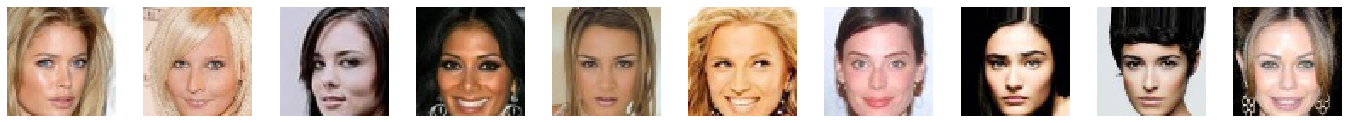

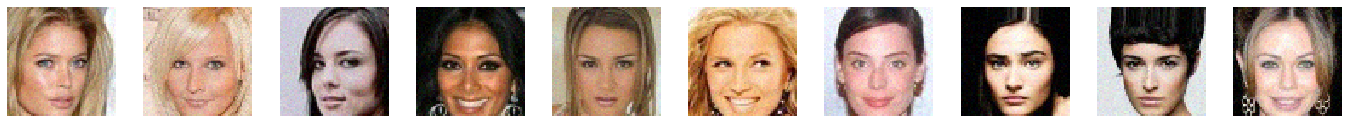

In [0]:
n0=0
n = 10

plot_images(test_images,n0,n)
plot_images(test_images_noisy,n0,n)

# input data examples

In [0]:
test_images.shape

(10000, 64, 64, 3)

## autoencoder


In [0]:
REP = 1024

inputs = Input(shape=(HEIGHT,WIDTH,CHAN)) 

X = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
X = MaxPooling2D((2, 2), padding='same')(X)
X = Conv2D(64, (3,3), activation='relu', padding='same')(X)
#X = Conv2D(16, (3,3), activation='relu', padding='same')(X)
X = Conv2D(4, (3,3), activation='relu', padding='same')(X)
X = Flatten()(X)
#X = Dense(REP, activation='relu')(X)

#X = Dense(32*32*4, activation='relu')(X)
X  = Reshape((32,32,4))(X)
X = Conv2DTranspose(64, (3,3), activation='relu', padding='same')(X)
X = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(X)
X = UpSampling2D((2, 2))(X)
DEC = Conv2DTranspose(CHAN, (3,3), activation='sigmoid', padding='same')(X)

autoencoder = Model(inputs, DEC)

autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 4)         2308      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 4)         0   

In [0]:
#tf.keras.utils.plot_model(model)

<h3>train model</h3>


In [0]:
lr0=0.001
annealer = LearningRateScheduler(lambda x: lr0 * 0.95 ** x) 
# 0.95^10=.60, ^20=.36, ^30=.21, ^40=.13

initial_epoch = 0
epochs = 20

steps_per_epoch = train_gen.n // batch_size
validation_steps = test_gen.n // batch_size

history=autoencoder.fit_generator(train_in_gen, 
                                steps_per_epoch=steps_per_epoch,
                                epochs=epochs,
                                validation_data=test_in_gen,
                                validation_steps=validation_steps,
                                initial_epoch=initial_epoch,
                                callbacks=[annealer]
                                   ) 

Epoch 1/20
250/250 [==============================] - 60s 239ms/step - loss: 0.5365 - val_loss: 0.5171
Epoch 2/20
250/250 [==============================] - 59s 235ms/step - loss: 0.5146 - val_loss: 0.5141
Epoch 3/20
250/250 [==============================] - 58s 233ms/step - loss: 0.5131 - val_loss: 0.5134
Epoch 4/20
250/250 [==============================] - 58s 233ms/step - loss: 0.5126 - val_loss: 0.5129
Epoch 5/20
250/250 [==============================] - 58s 234ms/step - loss: 0.5121 - val_loss: 0.5129
Epoch 6/20
250/250 [==============================] - 58s 234ms/step - loss: 0.5119 - val_loss: 0.5127
Epoch 7/20
250/250 [==============================] - 58s 233ms/step - loss: 0.5118 - val_loss: 0.5123
Epoch 8/20
250/250 [==============================] - 59s 234ms/step - loss: 0.5114 - val_loss: 0.5125
Epoch 9/20
250/250 [==============================] - 59s 235ms/step - loss: 0.5115 - val_loss: 0.5121
Epoch 10/20
250/250 [==============================] - 59s 235ms/step - l

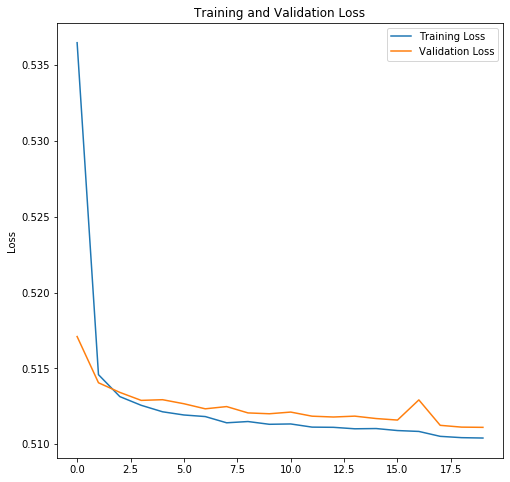

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
#plt.ylim([0,1])
plt.title('Training and Validation Loss')

plt.show()

In [0]:
amp=0.04
test_gen.reset()
test_in_gen = noise_generator(test_gen, amp)
test_images_noisy=np.vstack([next(test_in_gen)[0] for i in range(test_gen.n//batch_size)])

test_steps = test_gen.n//test_gen.batch_size
test_gen.reset()
test_images_output = autoencoder.predict_generator(noise_generator(test_gen,amp),
                              steps=test_steps,
                              verbose=1)



50/50 [==============================] - 9s 172ms/step


noisy images


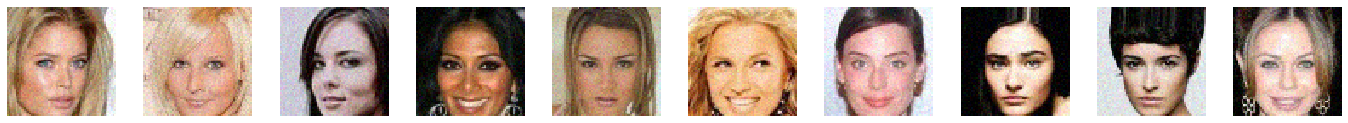


denoised images


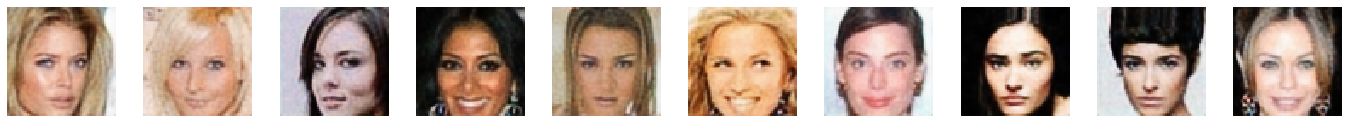


original images


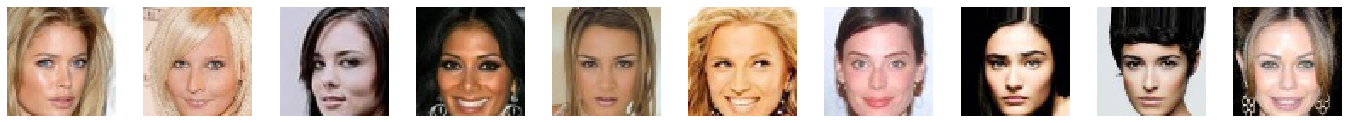

In [0]:
n0 = 0
n = 10

print("noisy images")
plot_images(test_images_noisy,n0,n)
print("\ndenoised images")
plot_images(test_images_output,n0,n)
print("\noriginal images")
plot_images(test_images,n0,n)

## **Result**

More noisy (amp=0.04) was added to the test images than the model trained for (amp=0.03 for training data). The noise is reduced effectively while some residue is visible due to the above reason. The quality of the image reconstruaction is acceptable.

## **Next steps**


early stop

noise type gaussian, speckle, s&p

defocused 

motion blur

gaussian blur, local

different model




# **References**


https://blog.keras.io/building-autoencoders-in-keras.html

https://medium.com/activating-robotic-minds/how-to-reduce-image-noises-by-autoencoder-65d5e6de543


